**importing libraries**

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import matplotlib.pyplot as plt

# Web scraping from: https://wine.com
**functions to get all the info about the products**

In [2]:
def url_contructor(page_number, url):
    first = url.split('7155', 1)[0]
    second = url.split('7155',1)[1]
    url = first + '7155/' + str(page_number) + second
    return url

In [3]:
def web_scrap():
    page = 0
    url_df = []
    web_data = {'product_name': [],
                'year':[],
                'varietal': [],
                'origin': [],
                'price': [],
                'rating': [],
                'rating_count':[]}
    df = pd.DataFrame(data=web_data)
    url = 'https://www.wine.com/list/wine/7155?pricemin=10&ratingmin=89'
    for x in range(1, 150):
        try:
            page += 1
            url_df.append(url_contructor(page, url))
        except Exception:
            continue
    for link in url_df:
        r = requests.get(link)
        soup = BeautifulSoup(r.content, 'html.parser')
        all_li = soup.find_all('li', {'class': 'prodItem'})
        for li in all_li:
            product_name = li.find('span', class_= 'prodItemInfo_name').string
            year = product_name.split()[-1]
            product_name = product_name.rsplit(' ', 1)[0]
            price = li.find('span', class_='productPrice_price-regWhole').string
            varietal = li.find('span', class_='prodItemInfo_varietal').string
            origin = li.find('span', class_='prodItemInfo_originText').string
            origin = origin.split()[-1]
            rating = li.find('span', class_='averageRating_average').string
            rating_count = li.find('span', class_='averageRating_number').string
            series = [product_name,year,varietal,origin,price,rating,rating_count]
            df.loc[len(df)]=series
    return df

**run to update DataFrame**

In [4]:
#df = web_scrap()

In [5]:
#df.to_csv('wine.csv')

**loading DataFrame**

In [6]:
df = pd.read_csv('wine.csv', index_col=0)
df

,product_name,year,varietal,origin,price,rating,rating_count
0,Dom Perignon Vintage with Gift Box,2012,Vintage Sparkling Wine,France,269,4.8,37
1,Robert Mondavi To Kalon Vineyard Reserve Caber...,2017,Cabernet Sauvignon,California,144,4.6,34
2,Chateau Fonbadet B de Fonbadet,2019,Bordeaux Red Blends,France,24,3.8,31
3,Joseph Phelps Cabernet Sauvignon,2019,Cabernet Sauvignon,California,89,4.5,46
4,Stag's Leap Wine Cellars Artemis Cabernet Sauv...,2019,Cabernet Sauvignon,California,77,4.4,72
...,...,...,...,...,...,...,...
3695,Wolffer Finca Wolffer Rose,2021,Rosé,Argentina,16,3.7,23
3696,Erath Leland Vineyard Pinot Noir,2018,Pinot Noir,Oregon,42,0.0,0
3697,Pendulum Cabernet Sauvignon,2020,Cabernet Sauvignon,Washington,16,4.1,7
3698,Chalk Hill Sonoma Coast Pinot Noir,2019,Pinot Noir,California,26,3.6,8


# Cleaning data for plots and machine learning

**removing products with no rating or not enough ratings**

In [7]:
df = df[df['rating'] != 0]
df = df[df['rating_count'] > 20]

**converting strings to integers**  

In [8]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()]
df['price']=df['price'].str.replace(',','')
df = df.astype({'price':'int'})
df = df.astype({'rating':'float'})
df['year'] = pd.to_numeric(df['year'])

**taking all the products from 2014 and above** 

In [9]:
df = df[df['year'] > 2014] #2014
df = df[df['year'] < 2021]
df = df.reset_index(drop=True)

**removing products that appear below the minimum times**\

In [10]:
df = df.groupby('varietal').filter(lambda x : len(x)>20).reset_index(drop=True) #20
df = df.groupby('origin').filter(lambda x : len(x)>5).reset_index(drop=True) #5

**adding categorical codes**

In [11]:
df['varietal_code'] = df['varietal'].astype('category').cat.codes
df['origin_code'] = df['origin'].astype('category').cat.codes

In [12]:
df

,product_name,year,varietal,origin,price,rating,rating_count,varietal_code,origin_code
0,Robert Mondavi To Kalon Vineyard Reserve Caber...,2017,Cabernet Sauvignon,California,144,4.6,34,1,2
1,Chateau Fonbadet B de Fonbadet,2019,Bordeaux Red Blends,France,24,3.8,31,0,4
2,Joseph Phelps Cabernet Sauvignon,2019,Cabernet Sauvignon,California,89,4.5,46,1,2
3,Stag's Leap Wine Cellars Artemis Cabernet Sauv...,2019,Cabernet Sauvignon,California,77,4.4,72,1,2
4,Faust Cabernet Sauvignon,2018,Cabernet Sauvignon,California,55,4.3,427,1,2
...,...,...,...,...,...,...,...,...,...
358,Clos de Nit Crianza,2016,Other Red Blends,Spain,13,3.6,38,3,7
359,Tikal Patriota,2018,Other Red Blends,Argentina,21,3.8,33,3,0
360,Vigilance Cimarron,2017,Other Red Blends,California,12,3.7,120,3,2
361,William Hill North Coast Cabernet Sauvignon,2019,Cabernet Sauvignon,California,14,3.9,34,1,2


# Plotting some usefull info 

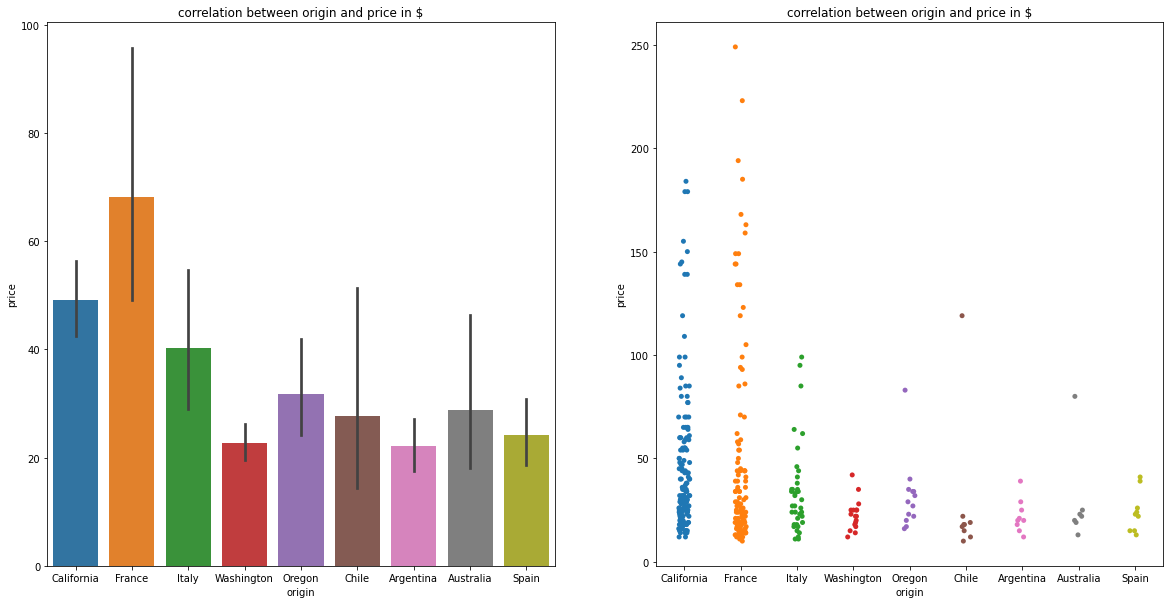

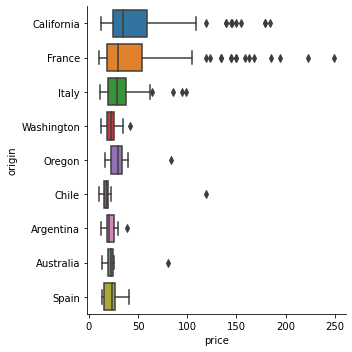

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
sns.barplot(x = 'origin', y = 'price', data = df,ax=ax1)
sns.stripplot(data=df.drop(df[df.price >= 250].index), x="origin", y="price",ax=ax2)
ax1.set_title('correlation between origin and price in $')
ax2.set_title('correlation between origin and price in $')
sns.catplot(data=df.drop(df[df.price >= 250].index), x="price", y="origin",kind="box")
plt.show()

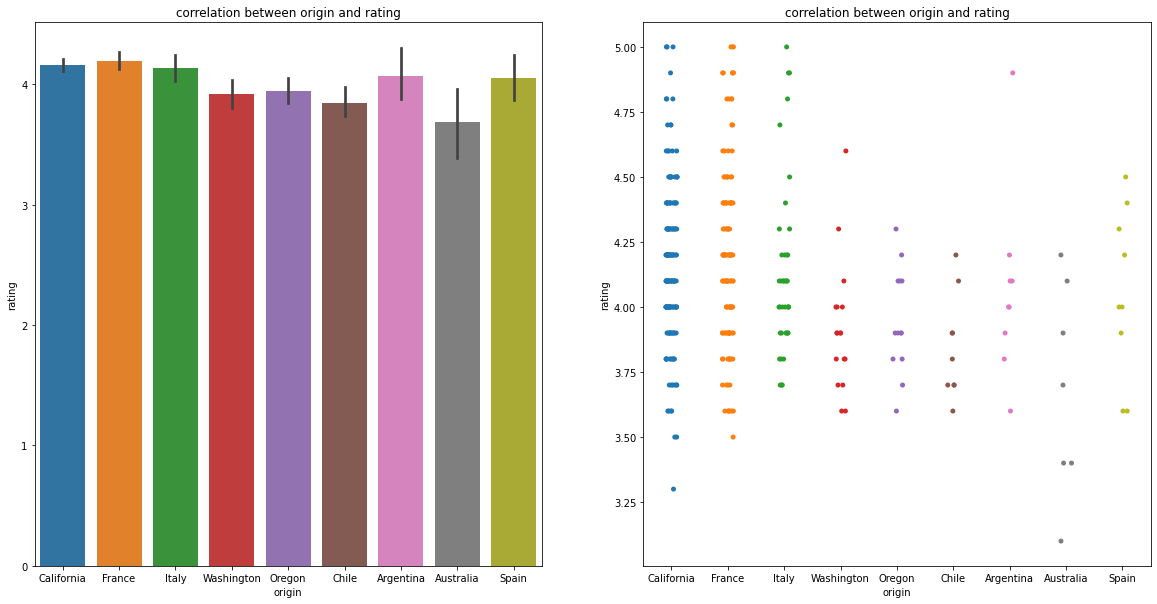

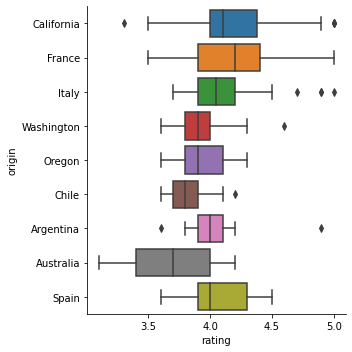

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
sns.barplot(x = 'origin', y = 'rating', data = df,ax=ax1)
sns.stripplot(data=df, x="origin", y="rating",ax=ax2)
ax1.set_title('correlation between origin and rating')
ax2.set_title('correlation between origin and rating')
sns.catplot(data=df.drop(df[df.price >= 250].index), x="rating", y="origin",kind="box")
plt.show()

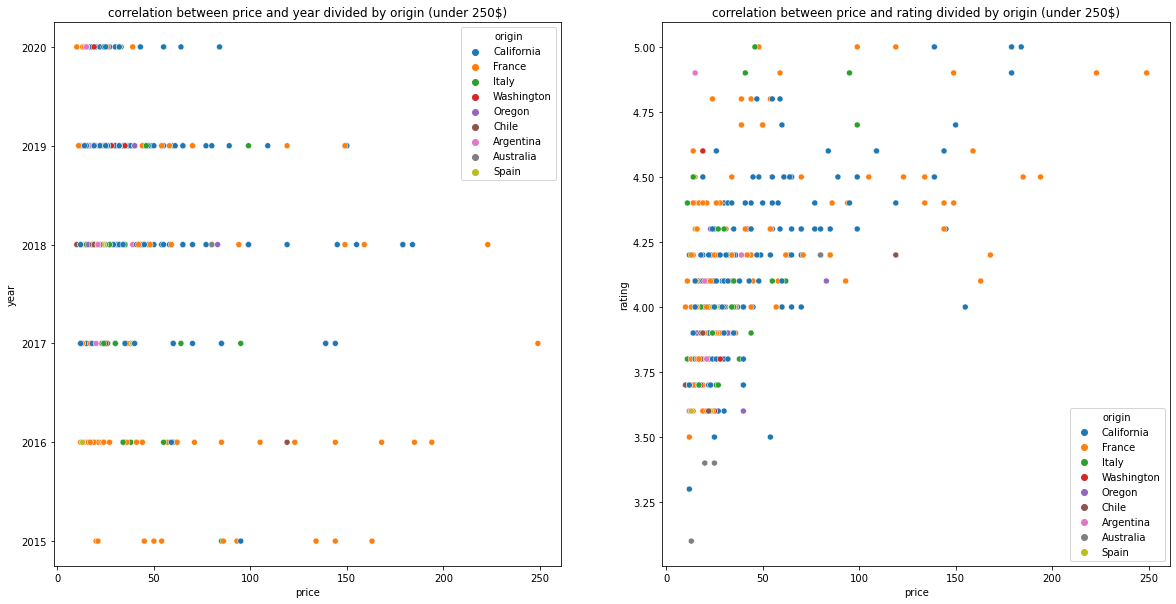

In [15]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
sns.scatterplot(data=df.drop(df[df.price >= 250].index), x="price", y="year",hue="origin",ax =ax1)
sns.scatterplot(data=df.drop(df[df.price >= 250].index), x="price", y="rating",hue="origin",ax =ax2)
ax1.set_title('correlation between price and year divided by origin (under 250$)')
ax2.set_title('correlation between price and rating divided by origin (under 250$)')
plt.show()

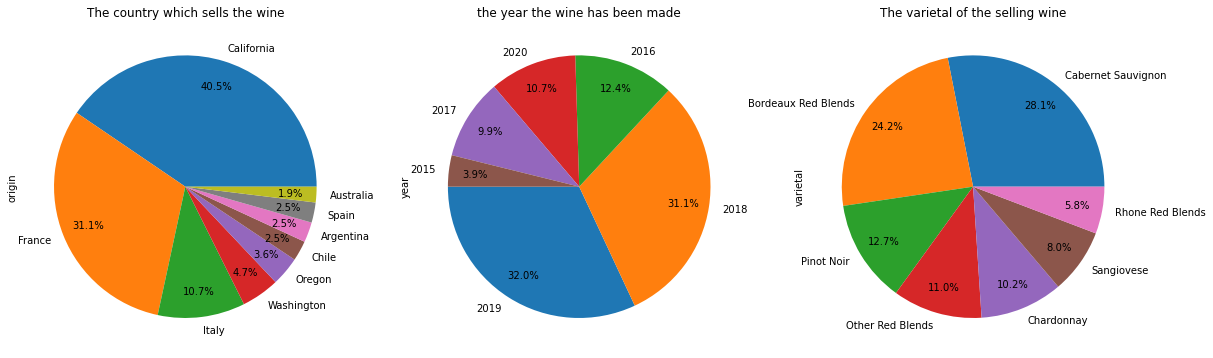

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,10))
df['origin'].value_counts().plot.pie(y='origin', figsize=(8, 8),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax1)
df['year'].value_counts().plot.pie(y='year', figsize=(8, 8),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax2,startangle=180)
df['varietal'].value_counts().plot.pie( figsize=(5, 10),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax3)
ax1.set_title("The country which sells the wine")
ax2.set_title('the year the wine has been made')
ax3.set_title('The varietal of the selling wine')
plt.show()

**adding rating_code to predict if the wine is worth to buy**

In [17]:
df['rating'].value_counts()
names = ['poor', 'high']
bins = (3.0, 4.1, 5.0)
df['quality'] = pd.cut(df['rating'], bins = bins, labels = names)
df

,product_name,year,varietal,origin,price,rating,rating_count,varietal_code,origin_code,quality
0,Robert Mondavi To Kalon Vineyard Reserve Caber...,2017,Cabernet Sauvignon,California,144,4.6,34,1,2,high
1,Chateau Fonbadet B de Fonbadet,2019,Bordeaux Red Blends,France,24,3.8,31,0,4,poor
2,Joseph Phelps Cabernet Sauvignon,2019,Cabernet Sauvignon,California,89,4.5,46,1,2,high
3,Stag's Leap Wine Cellars Artemis Cabernet Sauv...,2019,Cabernet Sauvignon,California,77,4.4,72,1,2,high
4,Faust Cabernet Sauvignon,2018,Cabernet Sauvignon,California,55,4.3,427,1,2,high
...,...,...,...,...,...,...,...,...,...,...
358,Clos de Nit Crianza,2016,Other Red Blends,Spain,13,3.6,38,3,7,poor
359,Tikal Patriota,2018,Other Red Blends,Argentina,21,3.8,33,3,0,poor
360,Vigilance Cimarron,2017,Other Red Blends,California,12,3.7,120,3,2,poor
361,William Hill North Coast Cabernet Sauvignon,2019,Cabernet Sauvignon,California,14,3.9,34,1,2,poor


**visualizing rating_code**

poor    207
high    156
Name: quality, dtype: int64

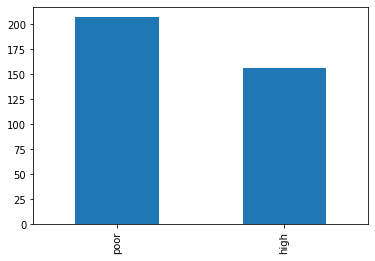

In [18]:
df['quality'].value_counts().plot.bar()
df['quality'].value_counts()


# Starting machine learning

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['quality'] = le.fit_transform(df['quality'])

**dividing to independent and dependent variables**

In [20]:
X = df.drop(columns=['rating','product_name','varietal','origin','quality'])
y = df['quality']

**creating classify function to match all the modeles**

In [21]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
def classify(model, X, y):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    # train the model
    model.fit(x_train, y_train)
    accuracy = model.score(x_test, y_test)
    print("Accuracy:", accuracy * 100)
    
    # predicting the results for the test set
    y_pred = model.predict(x_test)
    
    # cross-validation
    score = cross_val_score(model, X, y, cv=5)
    print("CV Score:", np.mean(score)*100)
    matrix = confusion_matrix(y_test, y_pred)
    matrix = pd.DataFrame(matrix,columns = ['0', '1'])
    matrix.plot.bar()
    return matrix

**LogisticRegression**

Accuracy: 76.92307692307693
CV Score: 76.837899543379


,0,1
0,25,15
1,6,45


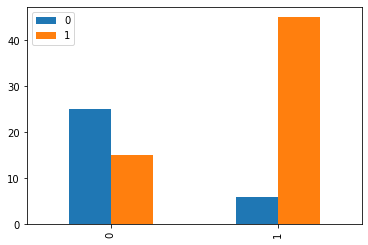

In [22]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
classify(model, X, y)


**DecisionTreeClassifier**

Accuracy: 65.93406593406593
CV Score: 68.02511415525115


,0,1
0,22,18
1,13,38


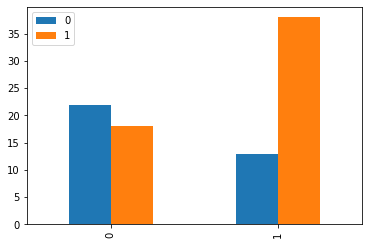

In [23]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
classify(model, X, y)

**RandomForestClassifier**

Accuracy: 75.82417582417582
CV Score: 74.08295281582953


,0,1
0,28,12
1,10,41


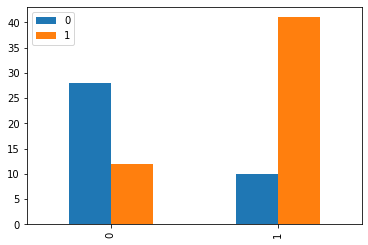

In [24]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
classify(model, X, y)

**ExtraTreesClassifier**

Accuracy: 76.92307692307693
CV Score: 72.43911719939116


,0,1
0,27,13
1,8,43


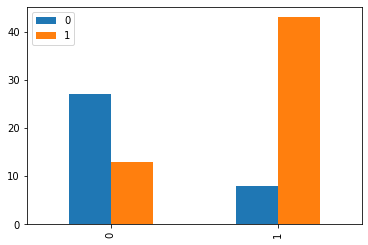

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
classify(model, X, y)